# Random Forest in Python

https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [1]:
import numpy as np
import pandas as pd

# Set random seed to ensure reproducible runs
RSEED = 50

# Start Simple with a decision tree
So this guy uses sklearn, I might try with Pytorch -> seems the way forward

Well the simple data is 6 data points like so. Labeled 1 and 0 such that we cannot linearly seperate the data

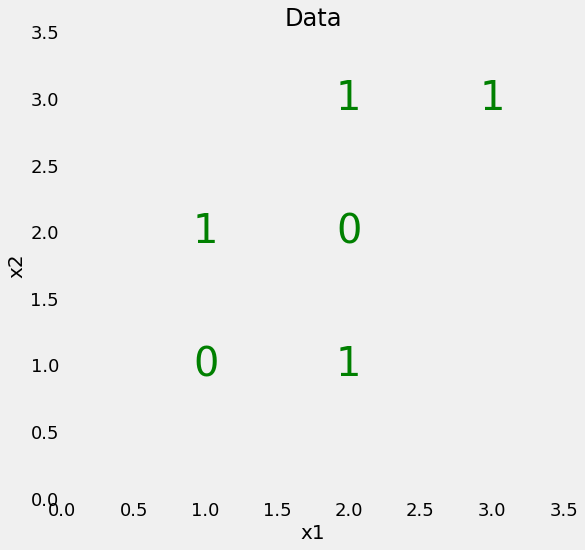

In [2]:
X = np.array([[2, 2], 
              [2, 1],
              [2, 3], 
              [1, 2], 
              [1, 1],
              [3, 3]])

y = np.array([0, 1, 1, 1, 0, 1])


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.figure(figsize = (8, 8))

# Plot each point as the label
for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, str(label), fontsize = 40, color = 'g',
             ha='center', va='center')
    
# Plot formatting
plt.grid(None);
plt.xlim((0, 3.5));
plt.ylim((0, 3.5));
plt.xlabel('x1', size = 20); plt.ylabel('x2', size = 20); plt.title('Data', size = 24)
plt.show()

Here we quickly build and train a single decision tree on the data using Scikit-Learn. The tree will learn how to separate the points, building a flowchart of questions based on the feature values and the labels. At each stage, the decision tree makes splits by maximizing the reduction in Gini impurity.

We'll use the default hyperparameters for the decision tree which means it can grow as deep as necessary in order to completely separate the classes. This will lead to overfitting because the model memorizes the training data, and in practice, we usually want to limit the depth of the tree so it can generalize to testing data.

In [3]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(X, y)

print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')
print(f'Model Accuracy: {tree.score(X, y)}')


Decision tree has 9 nodes with maximum depth 3.
Model Accuracy: 1.0


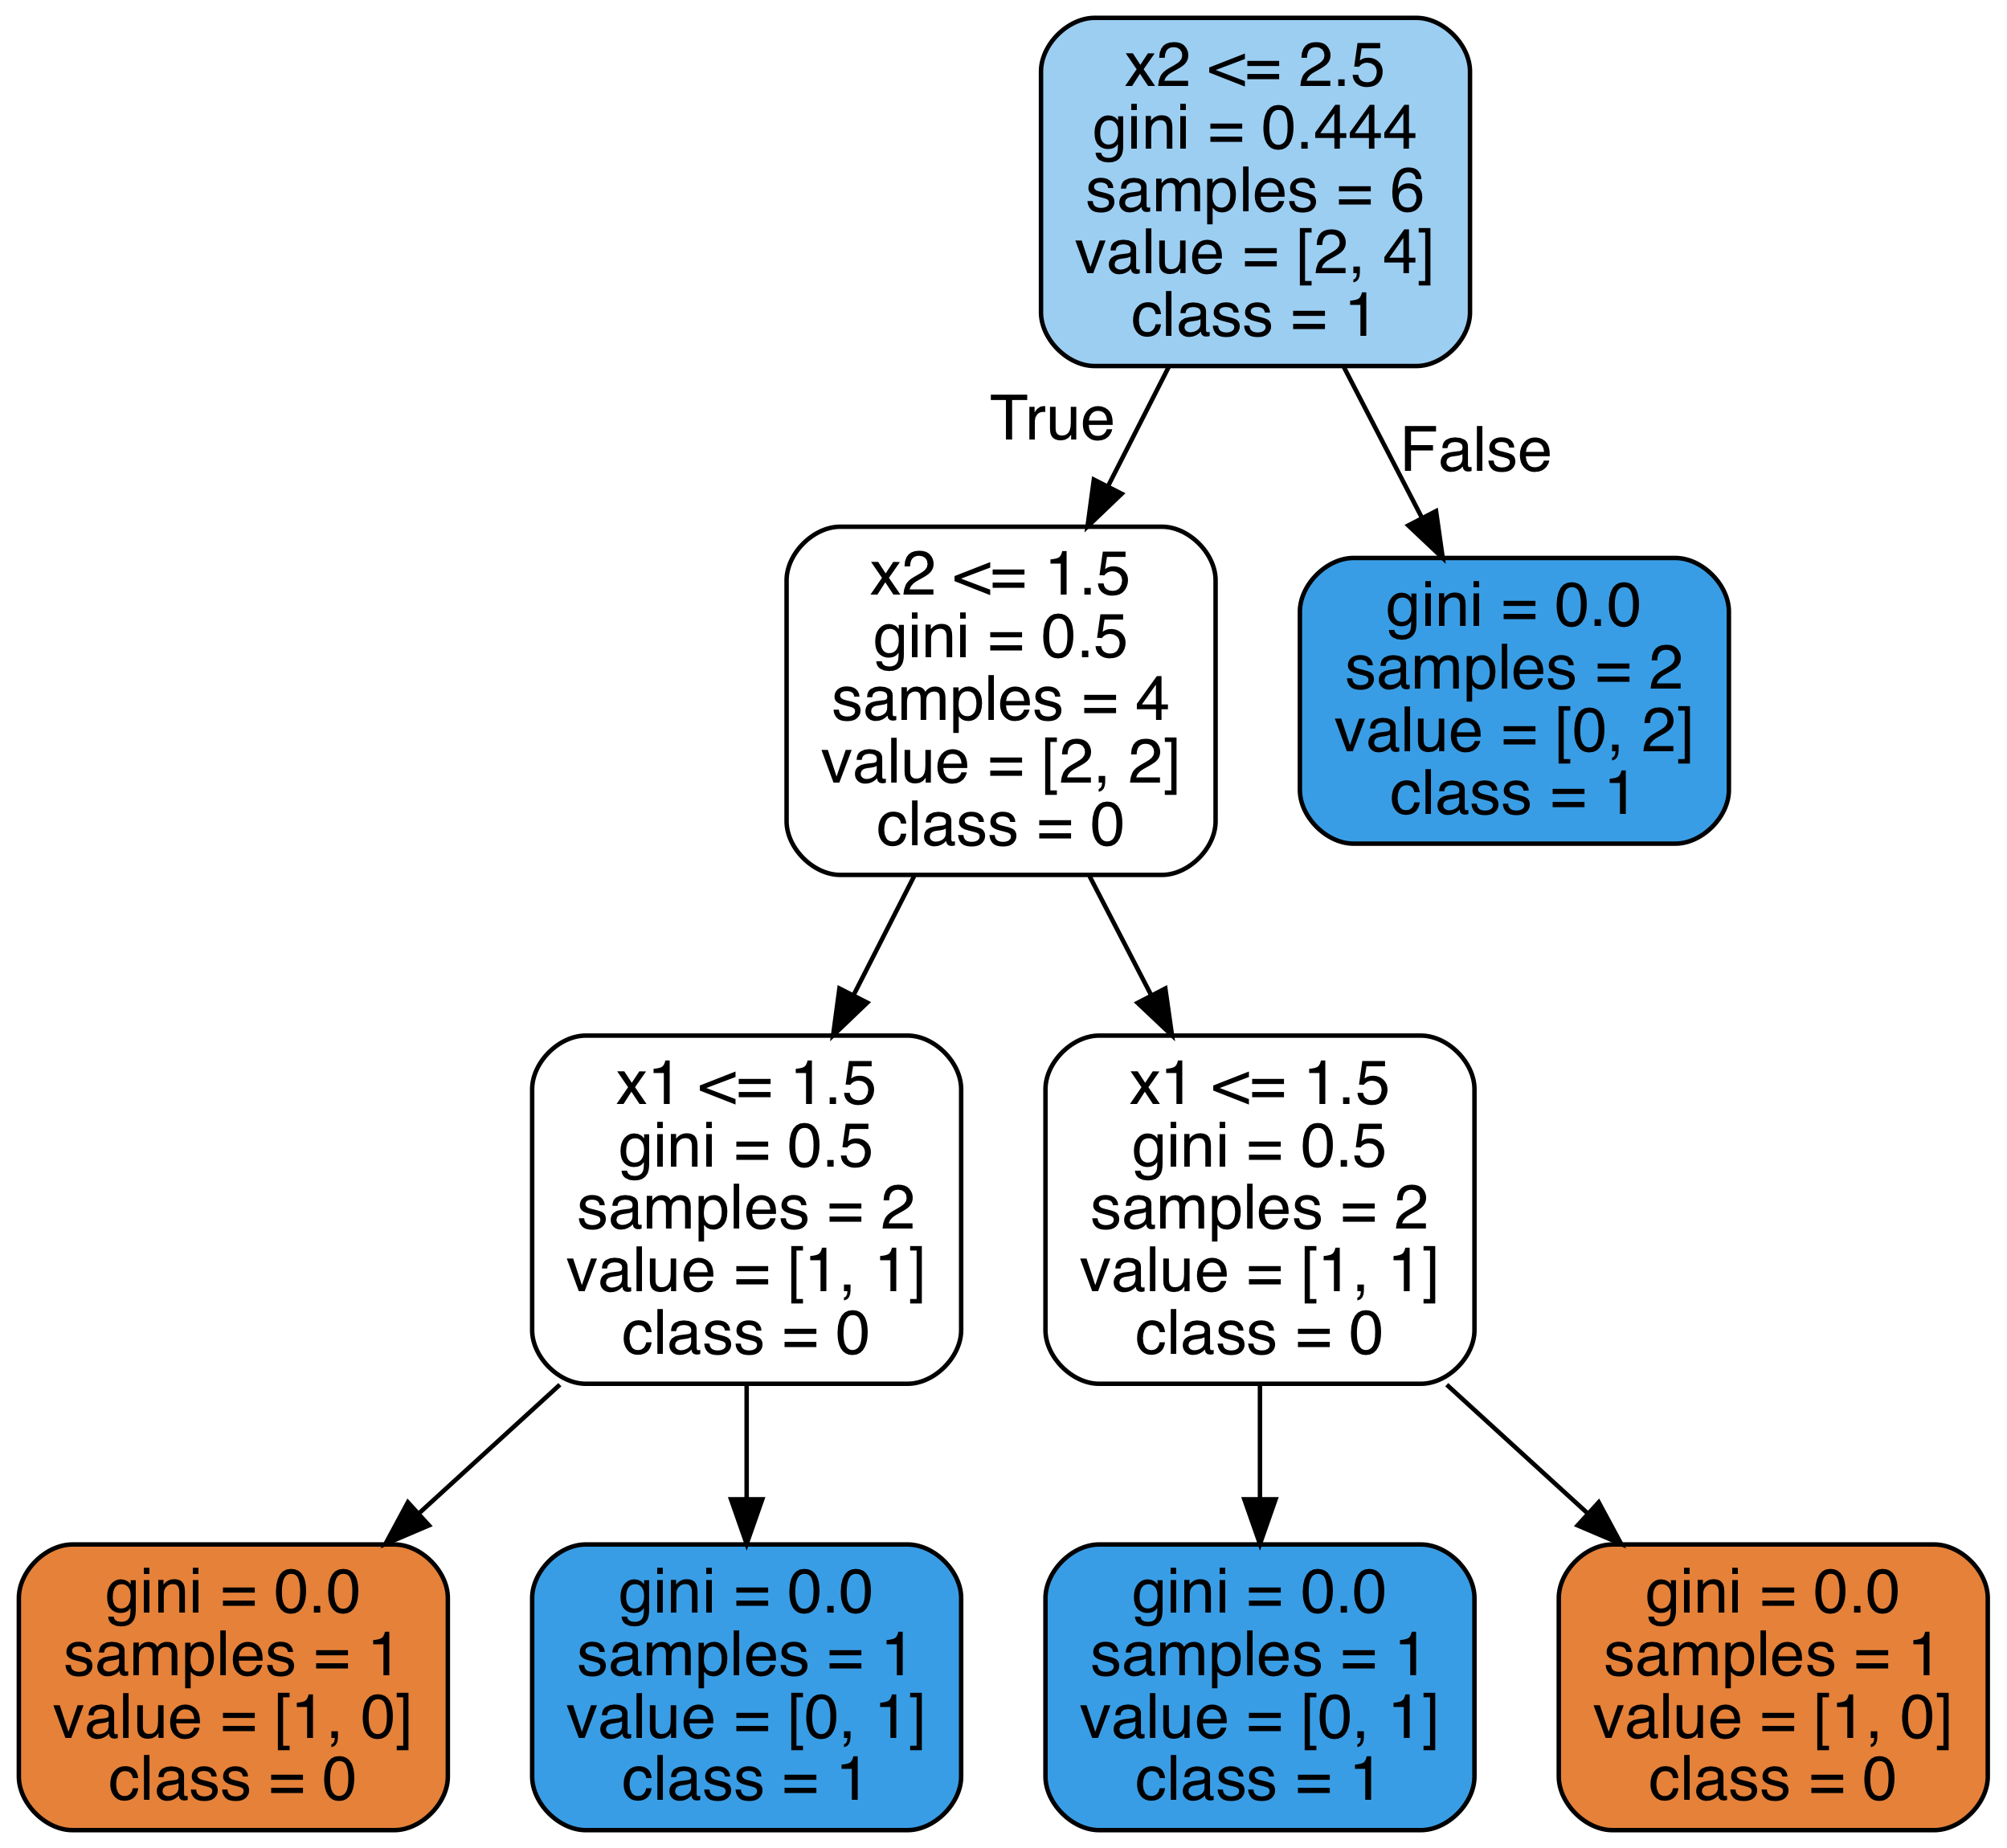

In [4]:
from sklearn.tree import export_graphviz

# Export as dot
export_graphviz(tree, 'tree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)


from subprocess import call
# Convert to png
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=400']);

from IPython.display import Image
Image('tree.png')

In practice, we usually want to limit the maximum depth of the decision tree (even in a random forest) so the tree can generalize better to testing data. Although this will lead to reduced accuracy on the training data, it can improve performance on the testing data.

Model Accuracy: 0.6666666666666666


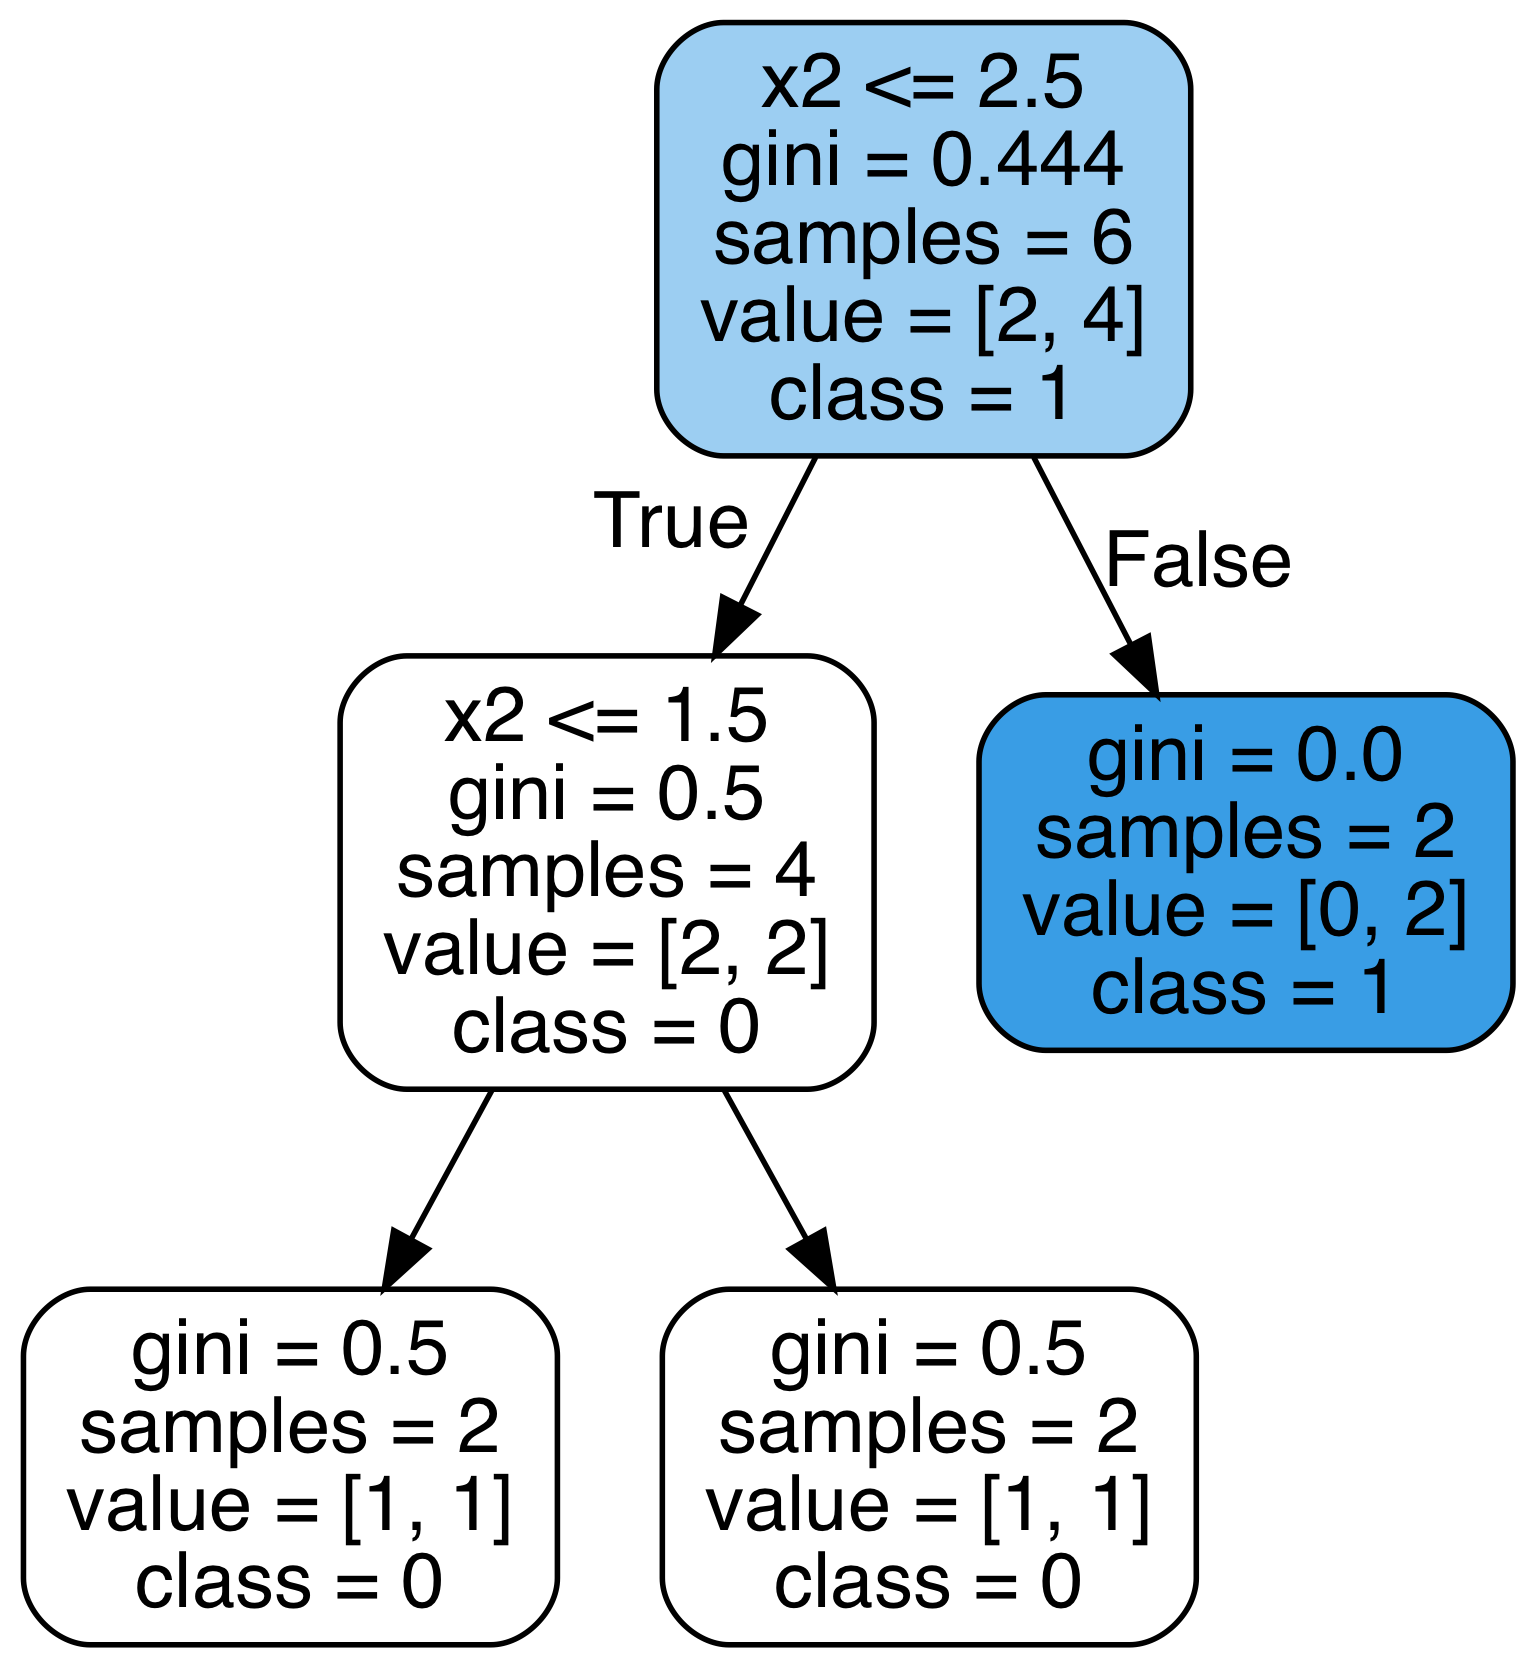

In [5]:
# Limit maximum depth and train
short_tree = DecisionTreeClassifier(max_depth = 2, random_state=RSEED)
short_tree.fit(X, y)

print(f'Model Accuracy: {short_tree.score(X, y)}')

# Export as dot
export_graphviz(short_tree, 'shorttree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)

call(['dot', '-Tpng', 'shorttree.dot', '-o', 'shorttree.png', '-Gdpi=400']);
Image('shorttree.png')

# Read in the Data and do a bit of cleaning

In [6]:
df = pd.read_csv('RandomForestPythonData/BehavioralRiskFactorSurveillanceSystem2015.csv').sample(100000, random_state = RSEED)
df = df.select_dtypes('number') #We'll read the data in and do a little cleaning.


df.head()

,_STATE,FMONTH,DISPCODE,SEQNO,_PSU,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
383119,49.0,4.0,1100.0,2.015009e+09,2.015009e+09,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
55536,9.0,9.0,1100.0,2.015005e+09,2.015005e+09,1.0,1.0,NaN,1.0,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
267093,34.0,10.0,1100.0,2.015011e+09,2.015011e+09,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
319092,41.0,4.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
420978,54.0,5.0,1100.0,2.015004e+09,2.015004e+09,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


In [7]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

1.0    81140
0.0    18579
Name: label, dtype: int64

In [8]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

In [9]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

# Imputation of Missing values
We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values.

In [11]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

#train.shape
#test.shape


In [12]:
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 12327 nodes with maximum depth 55.


Assess performance 

In [14]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')


Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.6639639045644772
Baseline ROC AUC: 0.5


Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.



# Evaluate the Decision Tree

A short function that calculates a number of metrics for the baseline (guessing the most common label in the training data), the testing predictions, and the training predictions. The function also plots the ROC curve where a better model is to the left and towards the top.


In [16]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    # If everything is predicted to be one 
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])#true pos/(false neg+true pos)
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])#true pos/(fal pos+tp)
    baseline['roc'] = 0.5  #Baseline ROC AUC
    
    results = {}
    
    # The actual results
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    # The results from the training set -> Just to see if there was any instance of over prediction
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    #
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # I dont get this now
    # https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
    # https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.83 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.66 Train: 1.0


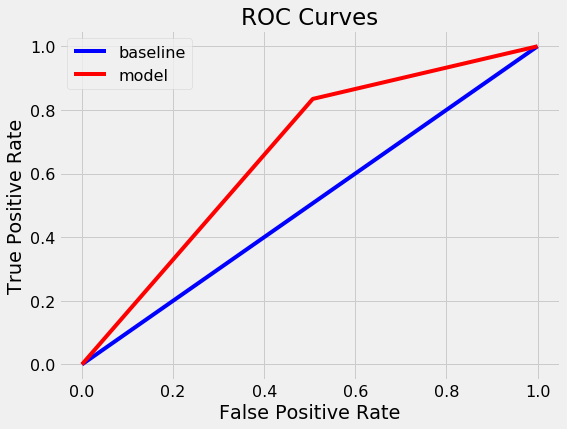

In [17]:
evaluate_model(predictions, probs, train_predictions, train_probs)

# Confusion Matrix 

This article is great for it 

https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62


In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2750  2824]
 [ 4027 20315]]


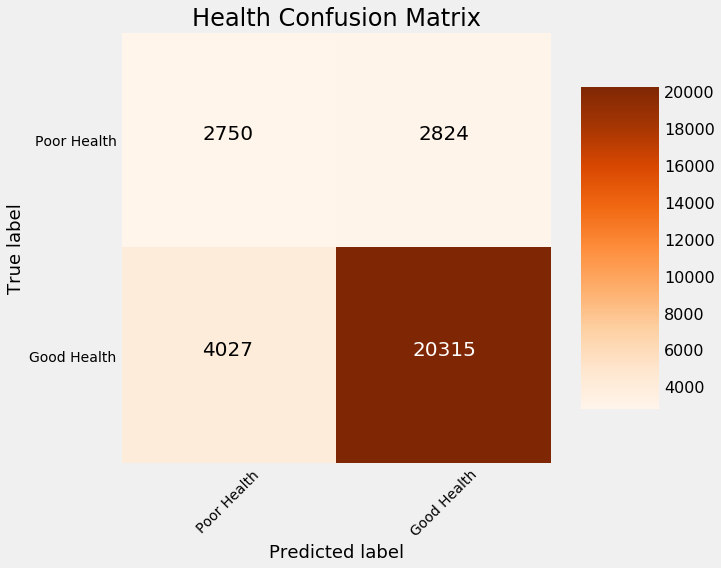

In [19]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

## Feature Importance

Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used.

In [20]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
62,DIFFWALK,0.191702
58,QLACTLM2,0.030550
51,EMPLOY1,0.023743
64,DIFFALON,0.018419
245,_BMI5,0.016785


# Random Forest

Now we can move on to a more powerful model, the random forest. This takes the idea of a single decision tree, and creates an ensemble model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

Creating and training a random forest in extremely easy in Scikit-Learn. The cell below is all you need.

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [23]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13396
Average maximum depth 46


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


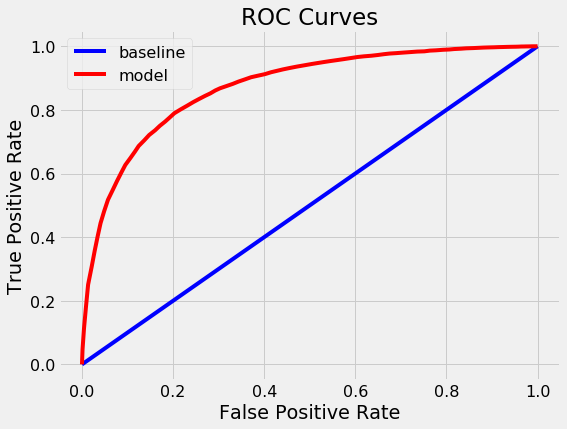

In [24]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)


Confusion matrix, without normalization
[[ 2438  3136]
 [ 1043 23299]]


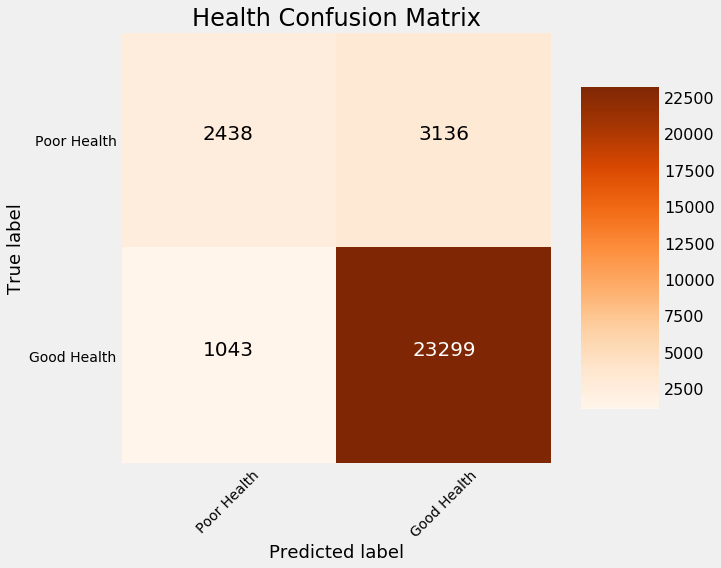

In [27]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

In [28]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
62,DIFFWALK,0.036200
58,QLACTLM2,0.030694
51,EMPLOY1,0.024156
64,DIFFALON,0.022699
59,USEEQUIP,0.016922
61,DECIDE,0.016271
307,_LMTSCL1,0.013424
53,INCOME2,0.011929
37,CHCCOPD1,0.011506
245,_BMI5,0.011497


## Random Forest Optimization through Random Search¶

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best.



In [30]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 20.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               